<b><b>Importing Necessary Dependencies</b></b>

In [1]:
import pandas as pd
import numpy as np
import text_normalizer as tn
import model_evaluation_utils as meu

np.set_printoptions(precision=2, linewidth=80)

2022-12-23 00:09:15.152021: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-23 00:09:15.288110: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-12-23 00:09:15.291186: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-23 00:09:15.291199: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

<b><b>Load and normalize data</b></b>

In [2]:
dataset = pd.read_csv(r'movie_reviews.csv')

# Take a peek at the data
print(dataset.head)
reviews = np.array(dataset['review'])
sentiments = np.array(dataset['sentiment'])

# Build train and test datasets
train_reviews = reviews[:35000]
train_sentiments = sentiments[:35000]
test_reviews = reviews[35000:]
test_sentiments = sentiments[35000:]

# Normalize datasets
norm_train_reviews = tn.normalize_corpus(train_reviews)
norm_test_reviews = tn.normalize_corpus(test_reviews)

<bound method NDFrame.head of                                                   review sentiment
0      One of the other reviewers has mentioned that ...  positive
1      A wonderful little production. <br /><br />The...  positive
2      I thought this was a wonderful way to spend ti...  positive
3      Basically there's a family where a little boy ...  negative
4      Petter Mattei's "Love in the Time of Money" is...  positive
...                                                  ...       ...
49995  I thought this movie did a down right good job...  positive
49996  Bad plot, bad dialogue, bad acting, idiotic di...  negative
49997  I am a Catholic taught in parochial elementary...  negative
49998  I'm going to have to disagree with the previou...  negative
49999  No one expects the Star Trek movies to be high...  negative

[50000 rows x 2 columns]>


/home/neel/anaconda3/lib/python3.9/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


<b><b>Tokenize train & test dataset</b></b>

In [3]:
tokenized_train = [tn.tokenizer.tokenize(text) for text in norm_train_reviews]
tokenized_test = [tn.tokenizer.tokenize(text) for text in norm_test_reviews]

<b><b>Build Vocabulary Mapping (word to index)</b></b>

In [4]:
from collections import Counter

# Build word to index vocabulary
token_counter = Counter([token for review in tokenized_train for token in review])
vocab_map = {item[0]: index+1 for index, item in enumerate(dict(token_counter).items())}
max_index = np.max(list(vocab_map.values()))
vocab_map['PAD_INDEX']=0
vocab_map['NOT_FOUND_INDEX']= max_index+1
vocab_size = len(vocab_map)
# View vocabulary size and part of the vocabulary map
print('Vocabulary Size:', vocab_size)
print('Sample slice of vocabulary map:', dict(list(vocab_map.items())[10:20]))

Vocabulary Size: 82095
Sample slice of vocabulary map: {'happen': 11, 'I': 12, 'first': 13, 'thing': 14, 'strike': 15, 'brutality': 16, 'unflinche': 17, 'scene': 18, 'violence': 19, 'set': 20}


<b><b>Encode and pad datasets & Encode prediction class labels</b></b>

In [13]:
from keras import preprocessing
from keras.preprocessing import sequence
from keras.utils import pad_sequences

# get max length of train corpus and initialize label encoder
le = LabelEncoder()
num_classes=2 # positive -> 1, negative -> 0
max_len = np.max([len(review) for review in tokenized_train])

## Train reviews data corpus
# Convert tokenized text reviews to numeric vectors
train_X = [[vocab_map[token] for token in tokenized_review] for tokenized_review in tokenized_train]
train_X = pad_sequences(train_X, maxlen=max_len) # pad 
## Train prediction class labels
# Convert text sentiment labels (negative\positive) to binary encodings (0/1)
train_y = le.fit_transform(train_sentiments)

## Test reviews data corpus
# Convert tokenized text reviews to numeric vectors
test_X = [[vocab_map[token] if vocab_map.get(token) else vocab_map['NOT_FOUND_INDEX'] for token in tokenized_review] for tokenized_review in tokenized_test]
test_X = pad_sequences(test_X, maxlen=max_len)
## Test prediction class labels
# Convert text sentiment labels (negative\positive) to binary encodings (0/1)
test_y = le.transform(test_sentiments)

# view vector shapes
print('Max length of train review vectors:', max_len)
print('Train review vectors shape:', train_X.shape, ' Test review vectors shape:', test_X.shape)
          

Max length of train review vectors: 1445
Train review vectors shape: (35000, 1445)  Test review vectors shape: (15000, 1445)


<b><b>Build the LSTM Model Architecture</b></b>

In [15]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, Dropout, SpatialDropout1D
from keras.layers import LSTM

EMBEDDING_DIM = 128 #Dimension for dense embeddings for each token
LSTM_DIM = 64 # Total LSTM units

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=EMBEDDING_DIM, input_length = max_len))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(LSTM_DIM, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation="sigmoid"))

model.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])

2022-12-23 00:50:17.052538: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-23 00:50:17.052891: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-23 00:50:17.052912: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (pop-os): /proc/driver/nvidia/version does not exist
2022-12-23 00:50:17.053657: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [16]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1445, 128)         10508160  
                                                                 
 spatial_dropout1d (SpatialD  (None, 1445, 128)        0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 10,557,633
Trainable params: 10,557,633
Non-trainable params: 0
_________________________________________________________________
None


<b><b>Visualize model architecture</b></b>

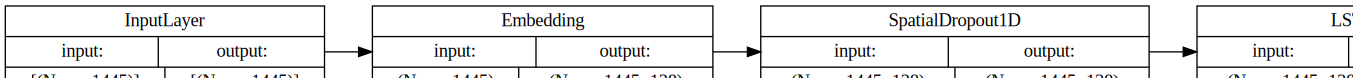

In [17]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True, show_layer_names=False, rankdir='LR').create(prog='dot', format='svg'))

<b><b>Train the model</b></b>

In [19]:
batch_size = 100
model.fit(train_X, train_y, epochs=5, batch_size=batch_size, shuffle=True, validation_split=0.1, verbose=1)

Epoch 1/5
315/315 [==============================] - 351s 1s/step - loss: 0.3620 - accuracy: 0.8353 - val_loss: 0.2694 - val_accuracy: 0.8946
Epoch 2/5
315/315 [==============================] - 347s 1s/step - loss: 0.1763 - accuracy: 0.9349 - val_loss: 0.2939 - val_accuracy: 0.8826
Epoch 3/5
315/315 [==============================] - 331s 1s/step - loss: 0.1014 - accuracy: 0.9658 - val_loss: 0.3556 - val_accuracy: 0.8760
Epoch 4/5
315/315 [==============================] - 334s 1s/step - loss: 0.0832 - accuracy: 0.9716 - val_loss: 0.4060 - val_accuracy: 0.8777
Epoch 5/5
315/315 [==============================] - 334s 1s/step - loss: 0.0406 - accuracy: 0.9874 - val_loss: 0.5662 - val_accuracy: 0.8694


<b><b>Predict and Evaluate Model Performance</b></b>

In [31]:
pred_test = model.predict_generator(test_X)

/tmp/ipykernel_5237/400084823.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  pred_test = model.predict_generator(test_X)


In [29]:
# predictions=[]
print(pred_test)
predictions=[]
for temp in pred_test:
    if temp[0] < temp[1]:
        predictions.append('positive')
    else:
        predictions.appedn('negative')
print(predictions)

[[2.44e-05]
 [1.00e+00]
 [4.83e-06]
 ...
 [4.76e-03]
 [6.76e-01]
 [3.60e-05]]


IndexError: index 1 is out of bounds for axis 0 with size 1

In [24]:
meu.display_model_performance_metrics(true_labels=test_sentiments, predicted_labels=predictions, classes=['positive', 'negative'])

Model Performance metrics:
------------------------------


ValueError: Found input variables with inconsistent numbers of samples: [15000, 0]